In [36]:
import os, os.path, re, imp
import numpy as np
from collections import Counter
from sys import getsizeof
import time
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.cluster import *
from code.modules.extract_model_tokens_encodings import extract_tokens
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import code.Parametrizer as Parametrizer

from code.Primitives import *
%matplotlib inline

In [35]:
def create_map_tokens_params():
    file_opened = open('data/tokensInterest.txt', 'r')
    primitives_lines = file_opened.readlines()
    tokens_codes = {line.split()[0] : int(ind) for ind,line in enumerate(primitives_lines)}    
    tokens_params = {line.split()[0] : int(line.split()[1]) for line in primitives_lines}    
    return (tokens_codes, tokens_params)

In [37]:
Parametrizer.parametrizing('sinla_(normal_(normal_(normal_(abs_(x0)))))')

RuntimeError: unidentifiable C++ exception

open_apple 1
data.shape =  (3400, 2)
model =  [plus2_(normal_(sinha_(abs_(X[0]))),parabola_(plus2_(X[0],abs_(abs_(X[0])))))]


NameError: name 'abs_' is not defined

heart_rate 1
data.shape =  (3400, 2)
model =  [linear_(plus2_(abs_(times2_(X[0],sinla_(X[0]))),sinla_(sinha_(X[0]))))]


NameError: name 'abs_' is not defined

chest_volume 1
data.shape =  (3400, 2)
model =  [parabola_(parabola_(normal_(sina_(X[0]))))]


KeyError: 'sina_'

open_apple 2
data.shape =  (3400, 2)
model =  [parabola_(expl_(lnl_(X[0])))]
optimal params=  [-0.38984138  0.27972895  1.99631064 -0.44087599  2.31745272  0.24523837
  0.93850532]
parabola_(expl_(lnl_(X[0])))
0.777790299892


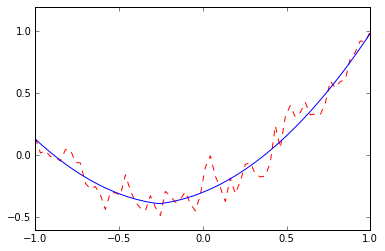

heart_rate 2
data.shape =  (3400, 2)
model =  [times2_(sinha_(neg_(X[0])),parabola_(expl_(sinha_(X[0]))))]
optimal params=  [ 1.3456222   8.35004729  3.87882437 -4.          1.          0.66483678
  0.55869589  0.12889388  8.11793621]
times2_(sinha_(neg_(X[0])),parabola_(expl_(sinha_(X[0]))))
1.37380798868


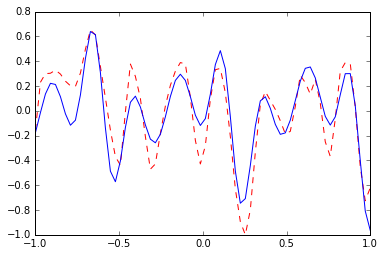

chest_volume 2
data.shape =  (3400, 2)
model =  [linear_(sina_(sina_(sina_(sina_(X[0])))))]


KeyError: 'sina_'

open_apple 3
data.shape =  (3400, 2)
model =  [lnl_(sina_(normal_(sina_(normal_(X[0])))))]


KeyError: 'sina_'

heart_rate 3
data.shape =  (3400, 2)
model =  [neg_(linear_(sina_(normal_(lnl_(normal_(X[0]))))))]


KeyError: 'sina_'

chest_volume 3
data.shape =  (3400, 2)
model =  [linear_(normal_(sina_(sina_(normal_(X[0])))))]


KeyError: 'sina_'

open_apple 4
data.shape =  (3400, 2)
model =  [plus2_(normal_(normal_(X[0])),lnl_(sina_(normal_(X[0]))))]


KeyError: 'sina_'

heart_rate 4
data.shape =  (3400, 2)
model =  [lnl_(normal_(sina_(sina_(expl_(X[0])))))]


KeyError: 'sina_'

chest_volume 4
data.shape =  (3400, 2)
model =  [parabola_(normal_(parabola_(sina_(X[0]))))]


KeyError: 'sina_'

open_apple 5
data.shape =  (3400, 2)
model =  [lnl_(linear_(normal_(sina_(sina_(X[0])))))]


KeyError: 'sina_'

heart_rate 5
data.shape =  (3400, 2)
model =  [sina_(plus2_(sina_(normal_(X[0])),expl_(sina_(X[0]))))]


KeyError: 'sina_'

chest_volume 5
data.shape =  (3400, 2)
model =  [parabola_(parabola_(normal_(frac2_(normal_(X[0]),X[0]))))]
optimal params=  [-0.336071   -0.3157463   1.00000011 -0.37727816 -1.13992693  1.00000115
  0.33821969  0.51242529  0.11803389  0.36703659]
parabola_(parabola_(normal_(frac2_(normal_(X[0]),X[0]))))
2.92260954188


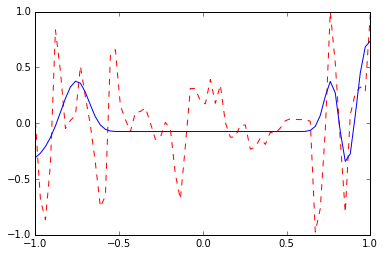

In [32]:
plt.figure(1)
%run ValidateFinalModel.py 'open_apple' 1
plt.figure(2)
%run ValidateFinalModel.py 'heart_rate' 1
plt.figure(3)
%run ValidateFinalModel.py 'chest_volume' 1
plt.figure(4)
%run ValidateFinalModel.py 'open_apple' 2
plt.figure(3)
%run ValidateFinalModel.py 'heart_rate' 2
plt.figure(1)
%run ValidateFinalModel.py 'chest_volume' 2
plt.figure(5)
%run ValidateFinalModel.py 'open_apple' 3
plt.figure(6)
%run ValidateFinalModel.py 'heart_rate' 3
plt.figure(7)
%run ValidateFinalModel.py 'chest_volume' 3
plt.figure(8)
%run ValidateFinalModel.py 'open_apple' 4
plt.figure(9)
%run ValidateFinalModel.py 'heart_rate' 4
plt.figure(10)
%run ValidateFinalModel.py 'chest_volume' 4
plt.figure(11)
%run ValidateFinalModel.py 'open_apple' 5
plt.figure(12)
%run ValidateFinalModel.py 'heart_rate' 5
plt.figure(13)
%run ValidateFinalModel.py 'chest_volume' 5

open_apple 1
data.shape =  (3400, 2)
model =  [sinla_(normal_(normal_(normal_(abs_(X[0])))))]
optimal params=  array([-4.99999995,  5.        ,  0.69916214,  0.54833872,  0.32816099,
        0.94165849,  0.10281391,  0.83712118,  0.65965171])
sinla_(normal_(normal_(normal_(abs_(X[0])))))
0.886683526806


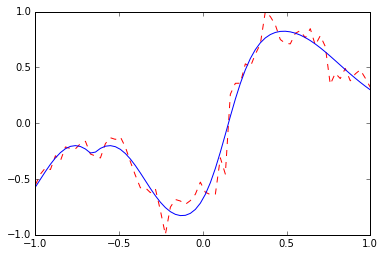

heart_rate 1
data.shape =  (3400, 2)
model =  [parabola_(sinla_(normal_(sinha_(abs_(X[0])))))]
optimal params=  array([-0.4999534 ,  1.44005073,  2.35444428,  1.87214908,  3.5       ,
        0.2755944 ,  1.17984506,  0.62693555,  7.84616441, -0.02193765])
parabola_(sinla_(normal_(sinha_(abs_(X[0])))))
2.7007354883


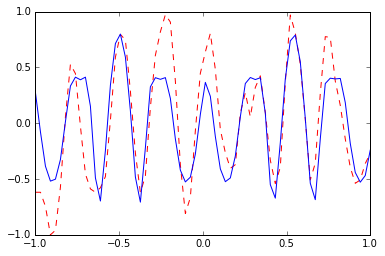

open_apple 2
data.shape =  (3400, 2)
model =  [parabola_(lnl_(parabola_(expl_(X[0]))))]
optimal params=  array([-0.36296506,  0.24764214,  1.        ,  0.51329505,  1.16573977,
        0.05446038, -1.92731684,  2.42279041,  0.06568878,  0.78853809])
parabola_(lnl_(parabola_(expl_(X[0]))))
0.774848601204


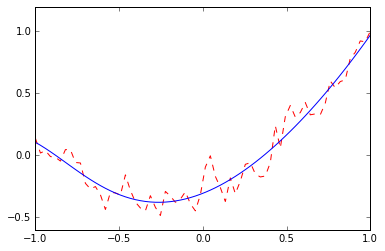

heart_rate 2
data.shape =  (3400, 2)
model =  [linear_(normal_(abs_(sinla_(sinla_(X[0])))))]
optimal params=  array([-0.62670258,  0.2379367 ,  0.29810418,  0.2298348 , -0.27237159,
        4.76345119,  3.86856328, -4.10238494,  4.12925293])
linear_(normal_(abs_(sinla_(sinla_(X[0])))))
1.69666068545


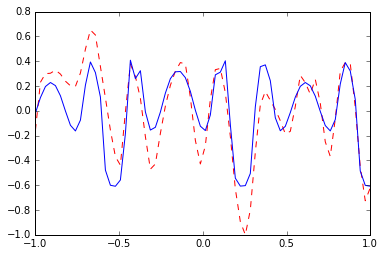

open_apple 3
data.shape =  (3400, 2)
model =  [linear_(sinla_(neg_(abs_(linear_(normal_(abs_(X[0])))))))]
optimal params=  array([-0.92243611,  1.4491351 ,  2.47044658,  3.97636981, -0.00954055,
       -0.53003029,  1.09176828,  0.40380737,  0.99335615, -0.63253297])
linear_(sinla_(neg_(abs_(linear_(normal_(abs_(X[0])))))))
1.6453515857


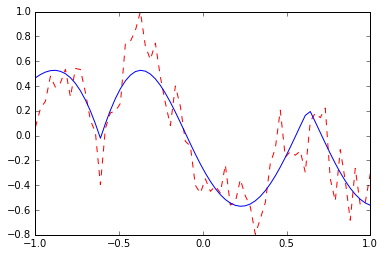

heart_rate 3
data.shape =  (3400, 2)
model =  [linear_(sinla_(normal_(parabola_(abs_(X[0])))))]
optimal params=  array([ 0.22151696,  0.59302824, -1.02489613,  3.5       ,  0.28145885,
        0.73923806, -0.87330433,  4.        ,  3.99737788, -0.43803761])
linear_(sinla_(normal_(parabola_(abs_(X[0])))))
2.5923078404


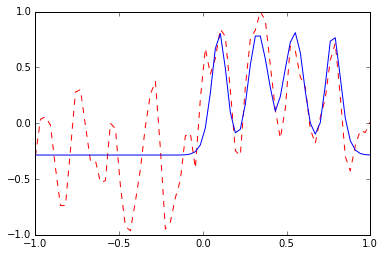

open_apple 4
data.shape =  (3400, 2)
model =  [times2_(frac2_(parabola_(normal_(abs_(X[0]))),X[0]),linear_(abs_(X[0])))]
optimal params=  array([ 0.40249159, -2.7413702 ,  5.33477678, -1.        ,  1.57952012,
       -0.32470204, -0.32754895,  2.09867479,  0.15231396])
times2_(frac2_(parabola_(normal_(abs_(X[0]))),X[0]),linear_(abs_(X[0])))
0.793274173056


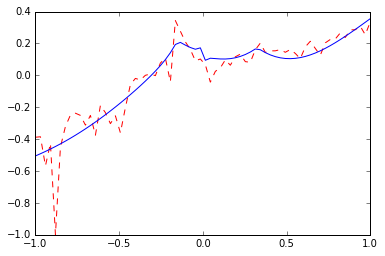

heart_rate 4
data.shape =  (3400, 2)
model =  [parabola_(normal_(normal_(abs_(X[0]))))]
optimal params=  array([ 1.18864766, -3.99999748,  1.81892962, -0.05765964,  0.53233363,
       -0.44481309,  0.05422587, -0.79010143])
parabola_(normal_(normal_(abs_(X[0]))))
1.5020773214


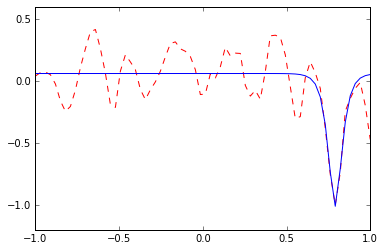

In [34]:
plt.figure()
%run ValidateFinalModel.py 'open_apple' 1
plt.figure()
%run ValidateFinalModel.py 'heart_rate' 1
plt.figure()
%run ValidateFinalModel.py 'open_apple' 2
plt.figure()
%run ValidateFinalModel.py 'heart_rate' 2
plt.figure()
%run ValidateFinalModel.py 'open_apple' 3
plt.figure()
%run ValidateFinalModel.py 'heart_rate' 3
plt.figure()
%run ValidateFinalModel.py 'open_apple' 4
plt.figure()
%run ValidateFinalModel.py 'heart_rate' 4

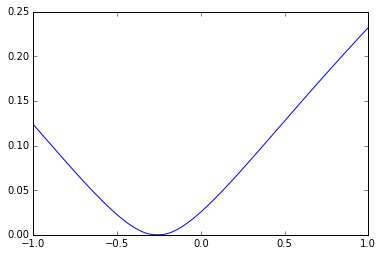

In [32]:
#w = [0.75945128579027477, 1.8257602509301276, 0.47967188925467663, 1.6194614328457326, 0.4164207414652753, 0.73103167165388483, 0.98798319227210962, 0.98412347875238682]
w = [ -0.37093584,   2.24388007,  15.22558277,   1.        ,
         0.9608944 ,   0.12963807,   0.5       ]
x = np.linspace(-1,1,100)
#plt.plot(x,x-normal_(w[0],w[1],normal_(w[2],w[3],normal_(w[4],w[5],normal_(w[6],w[7],x)))))
#model = 'linear_(w[0],w[1],normal_(w[2],w[3],normal_(w[4],w[5],sinla_(w[6],w[7],sinha_(w[8],w[9],x)))))'
#model = 'parabola_(w[0],w[1],w[2],normal_(w[3],w[4],inv_(sinla_(w[5],w[6],normal_(w[7],w[8],x)))))'

#plt.plot(x,normal_(w[4],w[5],sinla_(w[6],w[7],normal_(w[8],w[9],x))))
plt.plot(x,normal_(w[3],w[4],lnl_(w[5],w[6],x)))
plt.show()

In [23]:
from pyparsing import nestedExpr
txt = "(linear_(linear_(normal_(normal_(sinha_(X[0]))))))"
nst = nestedExpr('(',')').parseString(txt).asList()
import itertools
merged = list(itertools.chain(*nst))
merged

(linear_&linear_&normal_&normal_&sinha_


['linear_', ['linear_', ['normal_', ['normal_', ['sinha_', ['X[0]']]]]]]

** Sort rules in 'data/rules.txt' for convenience **

In [26]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/rules.txt','r')
file[-1].extend('\n')
lines = file.readlines()
lines_sorted = sorted(lines)
file.close()
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/rules.txt','w')
file.write(''.join(lines_sorted))
file.close()

['atana_(linear_(x0)) atana_(x0)\n', 'atana_(mult_(x0)) atana_(x0)\n', 'atana_(plus2_(x0,x0)) atana_(x0)\n', 'atana_(plus_(x0)) atana_(x0)\n', 'expl_(linear_(x0)) expl_(x0)\n', 'expl_(lnl_(x0)) linear_(x0)\n', 'expl_(mult_(x0)) expl_(x0)\n', 'expl_(plus2_(x0,x0)) expl_(x0)\n', 'expl_(plus_(x0)) expl_(x0)\n', 'hyperbola_(inv_(x0)) mult_(x0)\n', 'inv_(expl_(x0)) expl_(x0)\n', 'inv_(hyperbola_(x0)) mult_(x0)\n', 'inv_(inv_(x0)) x0\n', 'inv_(mult_(x0)) inv_(x0)\n', 'linear_(linear_(x0)) linear_(x0)\n', 'linear_(mult_(x0)) linear_(x0)\n', 'linear_(parabola_(x0)) parabola_(x0)\n', 'linear_(plus_(x0)) linear_(x0)\n', 'lnl_(expl_(x0)) linear_(x0)\n', 'lnl_(linear_(x0)) lnl_(x0)\n', 'lnl_(mult_(x0)) lnl_(x0)\n', 'lnl_(normal_(x0)) parabola_(x0)\n', 'lnl_(plus2_(x0,x0)) lnl_(x0)\n', 'lnl_(plus_(x0)) lnl_(x0)\n', 'mult_(hyperbola_(x0)) hyperbola_(x0)\n', 'mult_(hyperbola_(x0)) mult_(x0)\n', 'mult_(linear_(x0)) linear_(x0)\n', 'mult_(mult_(x0)) mult_(x0)\n', 'mult_(parabola_(x0)) parabola_(x0)\n',

In [ ]:
ax2 + bx + c -> 2ax + b = 0 -> x0 = -b  in [-2a,2a]

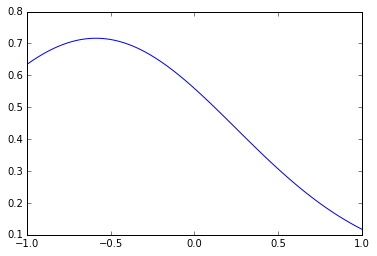

In [52]:
def cosh_(w0, w1, x):
    cosh_.NumParam = 2
    cosh_.NumVars = 1

    return np.cosh(x * (0.5 + abs(w1)) + w0)

x = np.linspace(-1,1,100)
plt.plot(x,normal_(w[8],w[9],x))
plt.show()

In [24]:
a = ([],[])

[1, 2, 2, 3, 4]

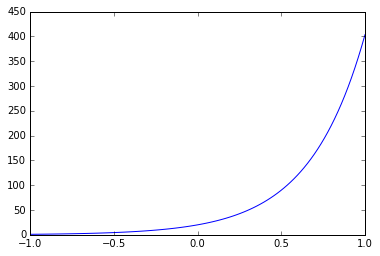

In [29]:
def expl_(w0, w1, x):
    expl_.NumParam = 2
    expl_.NumVars = 1
    return np.exp(x * w1 + w0)
w0 = 3
w1 = 3
x = np.linspace(-1,1,100)
y = expl_(w0, w1, x)
plt.plot(x,y)

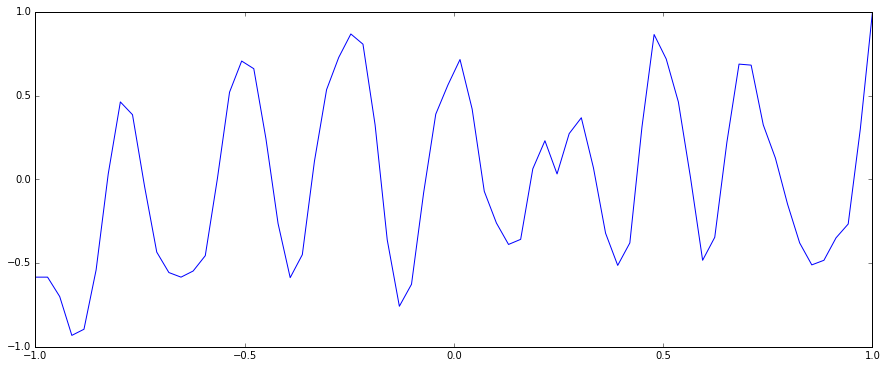

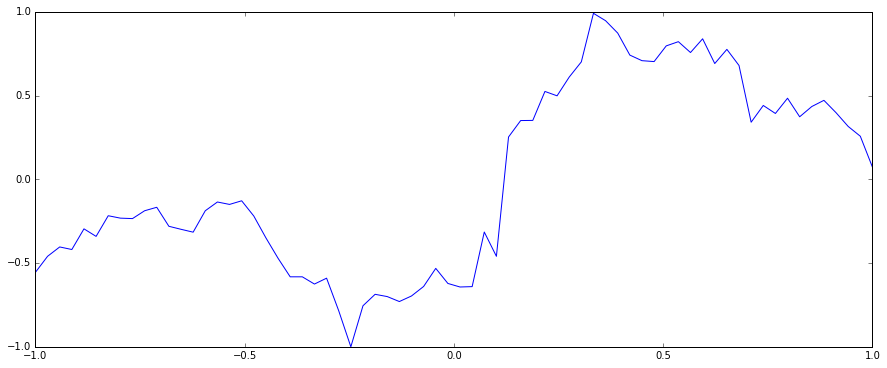

In [40]:
plt.figure(figsize = (15,6))

b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)
plt.figure(figsize = (15,6))
b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)

In [10]:
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration', 'open_apple']
file_path = 'ts_processing/'
number_of_rows = 3400
for ts_label in ts_labels:
    array = np.loadtxt(file_path + ts_label + '_full.txt')
    np.savetxt(file_path + ts_label + '.txt', array[0:number_of_rows], fmt = '%.3f')

In [27]:
dataset = pd.read_csv('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv')
time_series = dataset['Open']
backup_time_series = time_series

In [48]:
import re
b = 'plus2_(lnl_(linear_(x0)),atana_(linear_(x0)))'
re.sub(r'x(\d+)', r'X[\1]', b)
handle = re.sub(r'X\[(\d+)\]', r'x\1', 'x0')
handle

'x0'

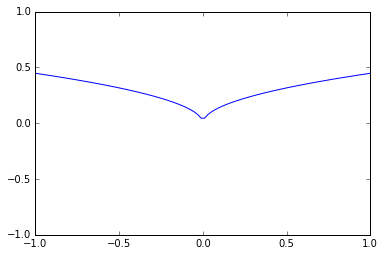

In [15]:
x = np.linspace(-1,1,100)
w0 = 0
w1 = 0.2

def sqrtl_(w0, w1, x):
    sqrtl_.NumParam = 2
    sqrtl_.NumVars = 1

    return np.sqrt(np.abs(x * w1 + w0))

plt.plot(x, sqrtl_(w0, w1, x))
plt.axis([-1, 1, -1, 1])
plt.show()

In [25]:
files_path = 'ts_processing/'
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
ts_labels = sorted(ts_labels)

number_ts_pieces = len(os.listdir(files_path)) / len(ts_labels)
# if the number is not divided 
if abs(number_ts_pieces - round(number_ts_pieces)) > 0:
    print('ERROR: invalid number of files in ', files_path)
else:
    number_ts_pieces = int(number_ts_pieces)    

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

file_names = sorted(os.listdir(files_path), key=natural_keys)

ERROR: invalid number of files in  ts_processing/


In [26]:
# set of labels of ts to classify
# labels = chest_volume, heart_rate, oxygen_concentration
labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
# locations of the ts
root_path = '/MVR_py/ts_processing/'
# extension of files containing data about ts
extension = '.txt'
# folder for output files
where_to_store_models = 'collected_models2/'
# specifies number of segments for ts to be split on
number_of_segments = 340

def retrieve_ts(label):
    
    dataset_filename     = '/data/data_to_fit.txt'
    init_models_filename = '/data/init_models.txt'
    
    
    
    DATA_LOCAL_PATH = root_path
    script_dir = os.path.dirname('__file__')
    parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
    DATA_FULL_PATH = parent_dir + DATA_LOCAL_PATH + label + extension
    # retrieve the data to fit from the specified file
    data_to_fit = np.loadtxt(DATA_FULL_PATH, delimiter = ',')
    data_to_fit = np.vstack((data_to_fit, np.linspace(0,1, len(data_to_fit)))).T
    return data_to_fit



In [27]:
def get_segment_of_ts(data, index_of_segment, length_of_segments):
    return data[index_of_segment * length_of_segments : (index_of_segment + 1) * length_of_segments, :]

ts_label = oxygen_concentration ; index_of_segment = 0


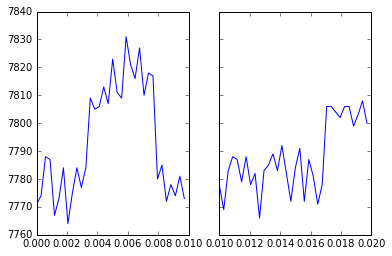

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

index_of_segment = 0
data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 0, 34)
X = segment[:,1]
y = segment[:,0]

ax1.plot(X,y)

index_of_segment = 0

print("ts_label =", 'oxygen_concentration', "; index_of_segment =", index_of_segment)

data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 1, 34)
X = segment[:,1]
y = segment[:,0]
ax2.plot(X,y)
plt.show()



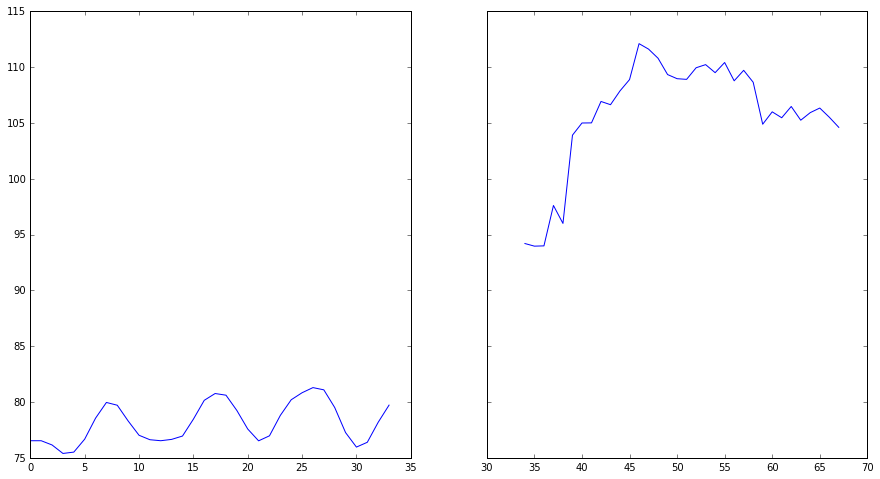

In [41]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt', 'r')
data = np.loadtxt(file) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)
num_seg = 0
num_rows = 34
ax1.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])
num_seg = 1
ax2.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])


In [28]:
np.savetxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple_full.txt', backup_time_series[:], fmt = '%.4f')

ts_label = chest_volume ; index_of_segment = 0


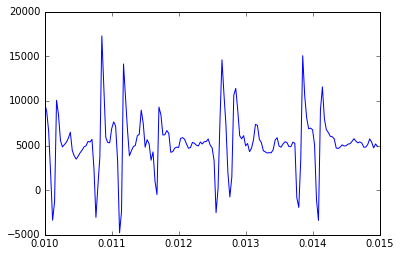

In [51]:
index_of_segment = 0
print("ts_label =", ts_labels[0], "; index_of_segment =", index_of_segment)
data = retrieve_ts(ts_labels[0])
segment = get_segment_of_ts(data, 2, int(data.shape[0] / 200))
X = segment[:,1]
y = segment[:,0]
plt.plot(X,y)
plt.show()

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

files_path = 'populations/first_segments2/'
file_names = sorted(os.listdir(files_path), key=natural_keys)
files_path_dest = 'populations/first_segments3/'

if not os.path.isdir(files_path_dest):
    os.makedirs(files_path_dest)

    
for file in file_names:
    number_of_file = int(file[:-4].split('_')[-1])
    if number_of_file >= 51:
        os.rename(files_path + file, files_path_dest + file)

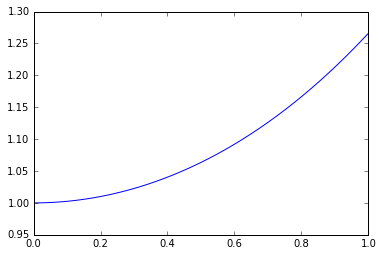

In [33]:
x = np.arange(0,1,.002)
y = np.i0(x)
plt.plot(x,y)

Script dealing with data removing from 'init_models'

In [35]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/init_models.txt', 'r')
lines = file.readlines()
file.close()
file = open('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv', 'w')
file_dest = open()
required_rows = 5000
for i in range(required_rows):
    file.write(lines[i])
file.close()